In [1]:
import neighbors
from neighbors import make_tables, dist, connect_stats, plot
%reload_ext autoreload
%autoreload 2

In [2]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm
import seaborn as sns
import statsmodels as sm
from statsmodels.stats import proportion
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import warnings
from tqdm import tqdm
import umap
import umap.plot

In [3]:
client = CAVEclient(global_only=True)
client = CAVEclient('minnie65_phase3_v1')

In [4]:
proofread_presyn = client.materialize.query_table('proofreading_status_public_release',split_positions=True)
proof_ids = np.unique(proofread_presyn.valid_id)

/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
presyn_df = ['allen_v1_column_types_slanted']
df_unfiltered = client.materialize.query_table(presyn_df[0],split_positions=True)

In [6]:
df = df_unfiltered.query('pt_root_id in @proof_ids').reset_index(drop=True)
df.loc[df['cell_type'] == '6CT', 'cell_type'] = '6P'
df.loc[df['cell_type'] == '6IT', 'cell_type'] = '6P'

In [7]:
L1 = [290,400]
L23 = [400,589]
L4 = [589,736]
L5 = [736,896]
L6 = [896,1061]
WM = [1061,1156]
depths = np.array([L1,L23,L4,L5,L6,WM])
depth_names = np.array(['23','23','4','5','6','6'])

In [8]:
df = make_tables.rename_by_layer(df,depths,depth_names)

In [9]:
np.unique(df.cell_type)

array(['23P', '23_BC', '23_BPC', '23_MC', '4P', '4_BC', '4_BPC', '4_MC',
       '5P_IT', '5P_NP', '5P_PT', '5_BC', '5_BPC', '5_MC', '5_P', '6_BC',
       '6_MC', '6_P', 'NGC', 'Omitted_P', 'Unsure'], dtype=object)

In [10]:
cell_types = ['23_BC','23_MC','23_BPC','4_BC','4_MC','4_BPC','5_BC','5_MC','5_BPC','Unsure']
#,'6_BC','6_BPC','6_MC']
pre_df,pre = [],[]
for i in range(len(cell_types)):
    pre_grab = df.query(f"cell_type == @cell_types[{i}]")
    pre_df.append(pre_grab)
for i in range(len(cell_types)):
    pre_type = []
    for j in range(len(pre_df[i])):
        p = pre_df[i].iloc[[j]]
        pre_type.append(p)
    pre.append(pre_type)

In [11]:
for i in range(len(pre)):
    print("{0:d} of {1:s}".format(len(pre[i]),cell_types[i]))

10 of 23_BC
4 of 23_MC
12 of 23_BPC
17 of 4_BC
5 of 4_MC
13 of 4_BPC
12 of 5_BC
5 of 5_MC
4 of 5_BPC
6 of Unsure


In [12]:
pd.options.mode.chained_assignment = None
main,syn,nonsyn,syndup = [],[],[],[]
badroot = []
for i in range(len(pre)):
    ma,sy,non,syd = [],[],[],[]
    br = []
    for j in tqdm(range(len(pre[i]))):
        try:
            m,s,n = make_tables.build_tables(client,pre[i][j],depths,depth_names)
            #,sd
            ma.append(m)
            sy.append(s)
            non.append(n)
            #syd.append(sd)
        except:
            br.append(pre[i][j])
            continue
    main.append(ma)
    syn.append(sy)
    nonsyn.append(non)
    syndup.append(syd)
    badroot.append(br)
badroot

  0%|                                                    | 0/10 [00:00<?, ?it/s]/var/folders/nm/l50fqsn14416wyl0lh09ckb40000gn/T/ipykernel_78322/447042670.py:9: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  m,s,n = make_tables.build_tables(client,pre[i][j],depths,depth_names)
100%|█████████████████████████████████████████████| 6/6 [01:11<00:00, 11.89s/it]


[[], [], [], [], [], [], [], [], [], []]

In [13]:
r_interval = 25
up = 400
threshold = 40

In [14]:
main_types,syn_types,nonsyn_types,f_type,s_type,syndup_types = [],[],[],[],[],[]
for i in range(len(pre)):
    bep = make_tables.final_prep(main[i],syn[i],nonsyn[i],r_interval,up)
    main_types.append(bep[0])
    syn_types.append(bep[1])
    nonsyn_types.append(bep[2])
    f_type.append(bep[3])
    s_type.append(bep[4])
    #syndup_types.append(bep[5])

100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.11s/it]


In [15]:
# main_thresh,syn_thresh,nonsyn_thresh,main_types_thresh,syn_types_thresh,nonsyn_types_thresh,f_type_thresh,s_type_thresh = [],[],[],[],[],[],[],[]
# for i in range(len(pre)):
#     bep = make_tables.final_prep(main[i],syn[i],nonsyn[i],r_interval,up,threshold=threshold)
#     main_thresh.append(bep[0])
#     syn_thresh.append(bep[1])
#     nonsyn_thresh.append(bep[2])
#     main_types_thresh.append(bep[3])
#     syn_types_thresh.append(bep[4])
#     nonsyn_types_thresh.append(bep[5])
#     f_type_thresh.append(bep[6])
#     s_type_thresh.append(bep[7])

In [16]:
# for i in range(len(pre)):
#     plot.makepdfs(client,pre[i],main[i],syn_types[i],nonsyn_types[i],s_type[i],f_type[i],r_interval,up)
#     #,MLEresults=True,threshold=None,display=False

#### Log-Likelihood Function:

<h4> $$ l(\theta|\chi) = \displaystyle\sum_{i=1}^{n_{conn}} log(p(\theta|\chi_{conn_i})) + \displaystyle\sum_{j=1}^{n_{unc}} log(1 - p(\theta|\chi_{unc_j}))  $$

where $\chi_{conn}$ and $\chi_{unc}$ are the subset of experimental variables (in this case, lateral intersomatic distance) for either connected or unconnected pairs.

#### Probability function, based on a Gaussian:

<h4> $$ p(\theta|\chi) = p_{max} e^{-\frac{(d-\mu)^{2}}{2\sigma^{2}}} $$

where model parameters $\theta = \{p_{max},\sigma\}$ and experimental variable $\chi = \{d\}$ are

$p_{max}$ = peak connection probability,
    
$\sigma$ = distace constant of connection probability (changes with cell class), 
    
$d$ = lateral (radial) intersomatic distance of somatic pair, and

$\mu$ = center of probability function, if we want it at a position other than zero mirons away from the soma.

In [17]:
res_comb,nconn_comb,nprobe_comb,res,nconn,nprobe,precat,cat = connect_stats.GaussianMLE(pre,s_type,f_type,syn_types,nonsyn_types,main)
pmax_comb = res_comb[0]
sigs_comb = res_comb[1]
moo_comb = res_comb[2]
pmax = res[0]
sigs = res[1]
moo = res[2]

/Users/aberg/allen_summerworkshop/src/neighbors/connect_stats.py:29: RuntimeWarning: invalid value encountered in true_divide
  p = np.around(np.nan_to_num((s_type[j]/(f_type[j]+s_type[j]))),4)
/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|█████████████████████████████████████████████| 6/6 [00:36<00:00,  6.02s/it]


In [18]:
# thresh = connect_stats.GaussianMLE(pre,s_type_thresh,f_type_thresh,syn_types_thresh,nonsyn_types_thresh,main,threshold=threshold)
# pmax_comb_thresh = thresh[0]
# sigs_comb_thresh = thresh[1]
# moo_comb_thresh = thresh[2]
# pmax_thresh = thresh[3]
# sigs_thresh = thresh[4]
# moo_thresh = thresh[5]
# precat_thresh = thresh[6]
# cat_thresh = thresh[7]

# precat = pd.merge(precat,precat_thresh)
# cat = pd.merge(cat,cat_thresh)

In [19]:
target_list = np.unique(main[0][0].cell_type)

In [21]:
#cat.to_csv("inh_pre_df.csv",index=False)

In [20]:
pcat,sigcat,cellname_array = [],[],[]
depthnconn,depthnprobe = [],[]
for i in range(len(pre)):
    ppp,sss = [],[]
    names = []
    dco,dpro = [],[]
    for j in range(len(pre[i])):
        ppp.append(precat[i].pmax.values[j])
        sss.append(precat[i].sigma_extent.values[j])
        y = np.around((precat[i].pt_position_y.values[j]*(4/1000)),1)
        if precat[i].cell_type.values[j] == 'Unsure':
            names.append(cell_types[i]+', y='+str(y))
        else:
            preid = str(client.materialize.query_table('allen_soma_coarse_cell_class_model_v1',
                                          filter_equal_dict = {'pt_root_id':precat[i].pt_root_id.values[j]},
                                          select_columns=['id','pt_root_id']).id.values[0])
            names.append(cell_types[i]+'_'+preid+', y='+str(y))
    pcat.append(ppp)
    sigcat.append(sss)
    cellname_array.append(names)
    
# pcat_thresh,sigcat_thresh = [],[]
# for i in range(len(pre)):
#     ppp,sss = [],[]
#     for j in range(len(pre[i])):
#         ppp.append(precat[i].pmax_thresh.values[j])
#         sss.append(precat[i].sigma_extent_thresh.values[j])
#     pcat_thresh.append(ppp)
#     sigcat_thresh.append(sss)

In [21]:
pdepth,predepth = [],[]
for k in range(len(pcat[0][0])):
    beh,deh = [],[]
    for i in range(len(pcat)):
        bah,dah = [],[]
        for j in range(len(pcat[i])):
            bah.append(pcat[i][j][k])
            dah.append(np.around((precat[i].pt_position_y.values[j]*(4/1000)),1))
        beh.append(bah)
        deh.append(dah)
    pdepth.append(beh)
    predepth.append(deh)
    
# pdepth_thresh,predepth_thresh = [],[]
# for k in range(len(pcat_thresh[0][0])):
#     beh,deh = [],[]
#     for i in range(len(pcat_thresh)):
#         bah,dah = [],[]
#         for j in range(len(pcat_thresh[i])):
#             bah.append(pcat_thresh[i][j][k])
#             dah.append(np.around((precat[i].pt_position_y.values[j]*(4/1000)),1))
#         beh.append(bah)
#         deh.append(dah)
#     pdepth_thresh.append(beh)
#     predepth_thresh.append(deh)

In [23]:
typename_array = []
for i in range(len(cell_types)):
    typename_array.append(cell_types[i]+', n='+str(len(pre[i])))

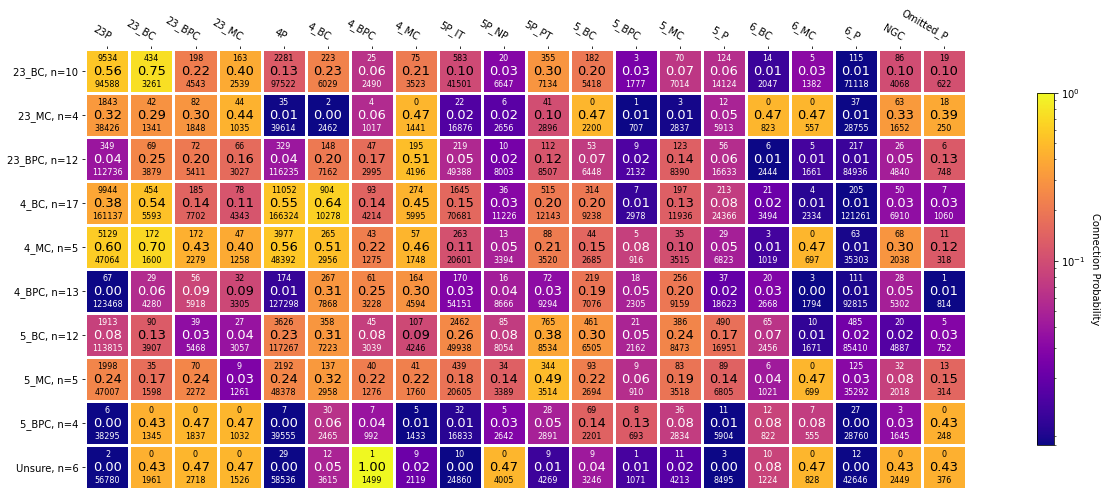

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(20,7)

im, cbar = plot.heatmap(pmax_comb, target_list, typename_array, ax=ax, cbar_kw={'shrink':0.8},
                   cmap="plasma", cbarlabel="Connection Probability", norm=LogNorm(vmin=0.008, vmax=1.0, clip=True))
texts = plot.annotate_heatmap(im, nconn_comb, nprobe_comb)

fig.tight_layout()
plt.show()
fig.savefig('./plots/heatmaps/public---inh_pmaxheatmap-{0:s}-{1:s}bin.pdf'.format(str(up),str(r_interval)))

Now to make the above plot, but for each cell, organized by depth...

In [26]:
for i in tqdm(range(len(pcat))):
    fig, ax = plt.subplots()
    fig.set_size_inches(22,10)
    
    warnings.filterwarnings("ignore")
    im, cbar = plot.heatmap(pcat[i], target_list, cellname_array[i], ax=ax, cbar_kw={'shrink':0.8},
                       cmap="plasma", cbarlabel="Connection Probability", norm=LogNorm(vmin=0.008, vmax=1.0, clip=True))
    texts = plot.annotate_heatmap(im, nconn[i], nprobe[i])

    fig.tight_layout()
    plt.close(fig)
    fig.savefig('./plots/{0:s}/pmaxheatmap-{1:s}-{2:s}bin.pdf'.format(cell_types[i],str(up),str(r_interval)))
    fig.savefig('./plots/heatmaps/{0:s}_pmaxheatmap-{1:s}-{2:s}bin.pdf'.format(cell_types[i],str(up),str(r_interval)))

100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.38s/it]


In [39]:
for i in tqdm(range(len(pcat))):
    fig, ax = plt.subplots()
    fig.set_size_inches(22,10)
    
    warnings.filterwarnings("ignore")
    im, cbar = plot.heatmap(sigcat[i], target_list, cellname_array[i], ax=ax, cbar_kw={'shrink':0.8},
                       cmap="plasma", cbarlabel="Sigma")
    texts = plot.annotate_heatmap(im, nconn[i], nprobe[i], valfmt="{x:.1f}")

    fig.tight_layout()
    plt.close(fig)
    fig.savefig('./plots/{0:s}/sigmaheatmap-{1:s}-{2:s}bin.pdf'.format(cell_types[i],str(up),str(r_interval)))
    fig.savefig('./plots/heatmaps/{0:s}_sigmaheatmap-{1:s}-{2:s}bin.pdf'.format(cell_types[i],str(up),str(r_interval)))

100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.13s/it]


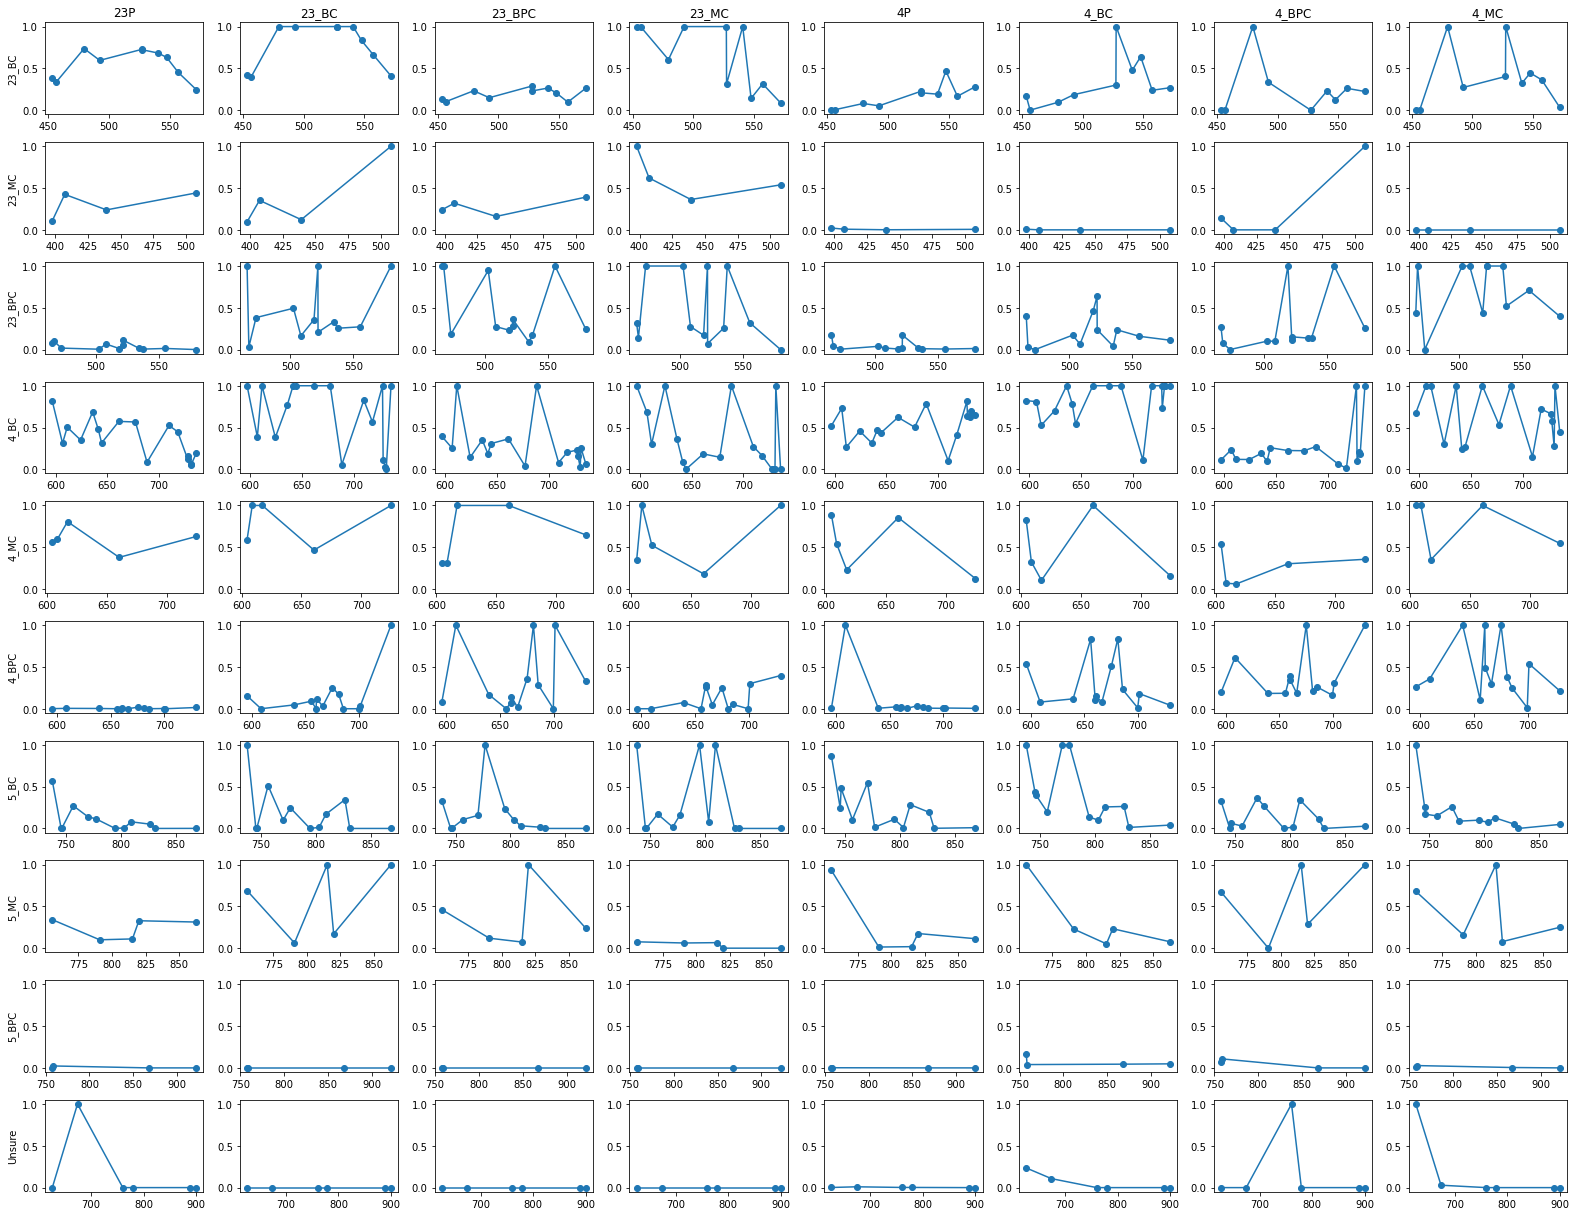

In [41]:
fig, ax = plt.subplots(int(len(pdepth[0])),8)
fig.set_size_inches(22,17)

for i in range(len(pdepth[0])):
    for j in range(8):
        ax[i,j].plot(predepth[j][i],pdepth[j][i],marker='o')
        ax[i,0].set_ylabel(cell_types[i])
        ax[i,j].set_ylim(-.05,1.05)
        ax[0,j].set_title(target_list[j])
        fig.tight_layout()
fig.savefig('./plots/heatmaps/public--lowlayertargets-{0:s}-{1:s}bin.pdf'.format(str(up),str(r_interval)))

100%|███████████████████████████████████████████| 10/10 [02:11<00:00, 13.18s/it]


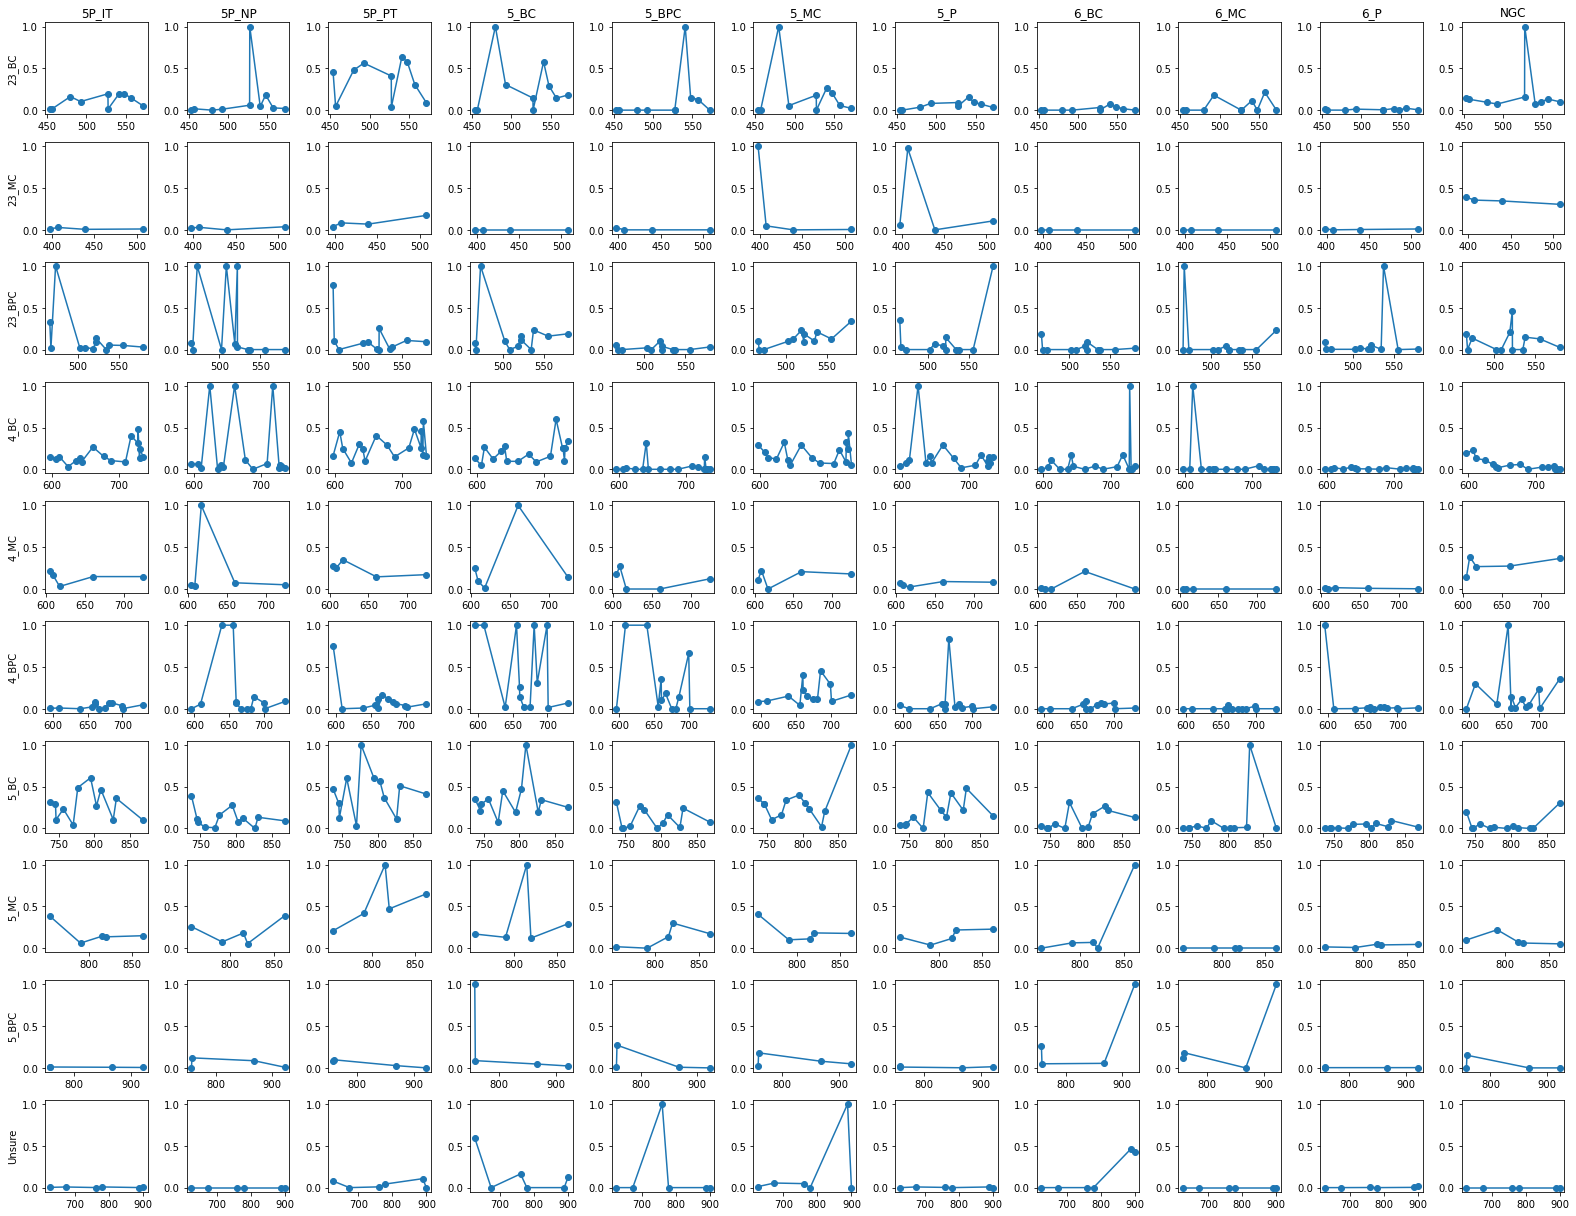

In [42]:
fig, ax = plt.subplots(int(len(pdepth[0])),11)
fig.set_size_inches(22,17)

for i in tqdm(range(len(pdepth[0]))):
    for j in range(11):
        ax[i,j].plot(predepth[j+8][i],pdepth[j+8][i],marker='o')
        ax[i,0].set_ylabel(cell_types[i])
        ax[i,j].set_ylim(-.05,1.05)
        ax[0,j].set_title(target_list[j+8])
        fig.tight_layout()
fig.savefig('./plots/heatmaps/public--highlayertargets-{0:s}-{1:s}bin.pdf'.format(str(up),str(r_interval)))

In [62]:
reducer = umap.UMAP()

    UMAP(a=None, angular_rp_forest=False, b=None,

         force_approximation_algorithm=False, init='spectral', learning_rate=1.0,

         local_connectivity=1.0, low_memory=False, metric='euclidean',

         metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,

         n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',

         output_metric_kwds=None, random_state=42, repulsion_strength=1.0,

         set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',

         target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,

         transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [64]:
target_list

array(['23P', '23_BC', '23_BPC', '23_MC', '4P', '4_BC', '4_BPC', '4_MC',
       '5P_IT', '5P_NP', '5P_PT', '5_BC', '5_BPC', '5_MC', '5_P', '6_BC',
       '6_MC', '6_P', 'NGC', 'Omitted_P'], dtype=object)

In [122]:
exc_targets = []
for i in range(len(target_list)):
    exists = target_list[i] in cell_types
    if exists == False:
        exc_targets.append(target_list[i])

exc_targets_thresh = []
for i in range(len(target_list)):
    exists = target_list[i] in cell_types
    if exists == False:
        exc_targets_thresh.append(target_list[i]+"_thresh")
        
inh_targets_thresh = []
for i in range(len(target_list)):
    exists = target_list[i] in cell_types
    if exists == True:
        inh_targets_thresh.append(target_list[i]+"_thresh")

In [123]:
# "num_targets",
# "num_syn",
# "pmax",
# "sigma_ext",

In [44]:
# comb = cat[target_list].values
# scaled_comb = StandardScaler().fit_transform(comb)
# embed_comb = reducer.fit_transform(scaled_comb)
# embed_comb.shape

100%|███████████████████████████████████████████| 15/15 [02:47<00:00, 11.18s/it]


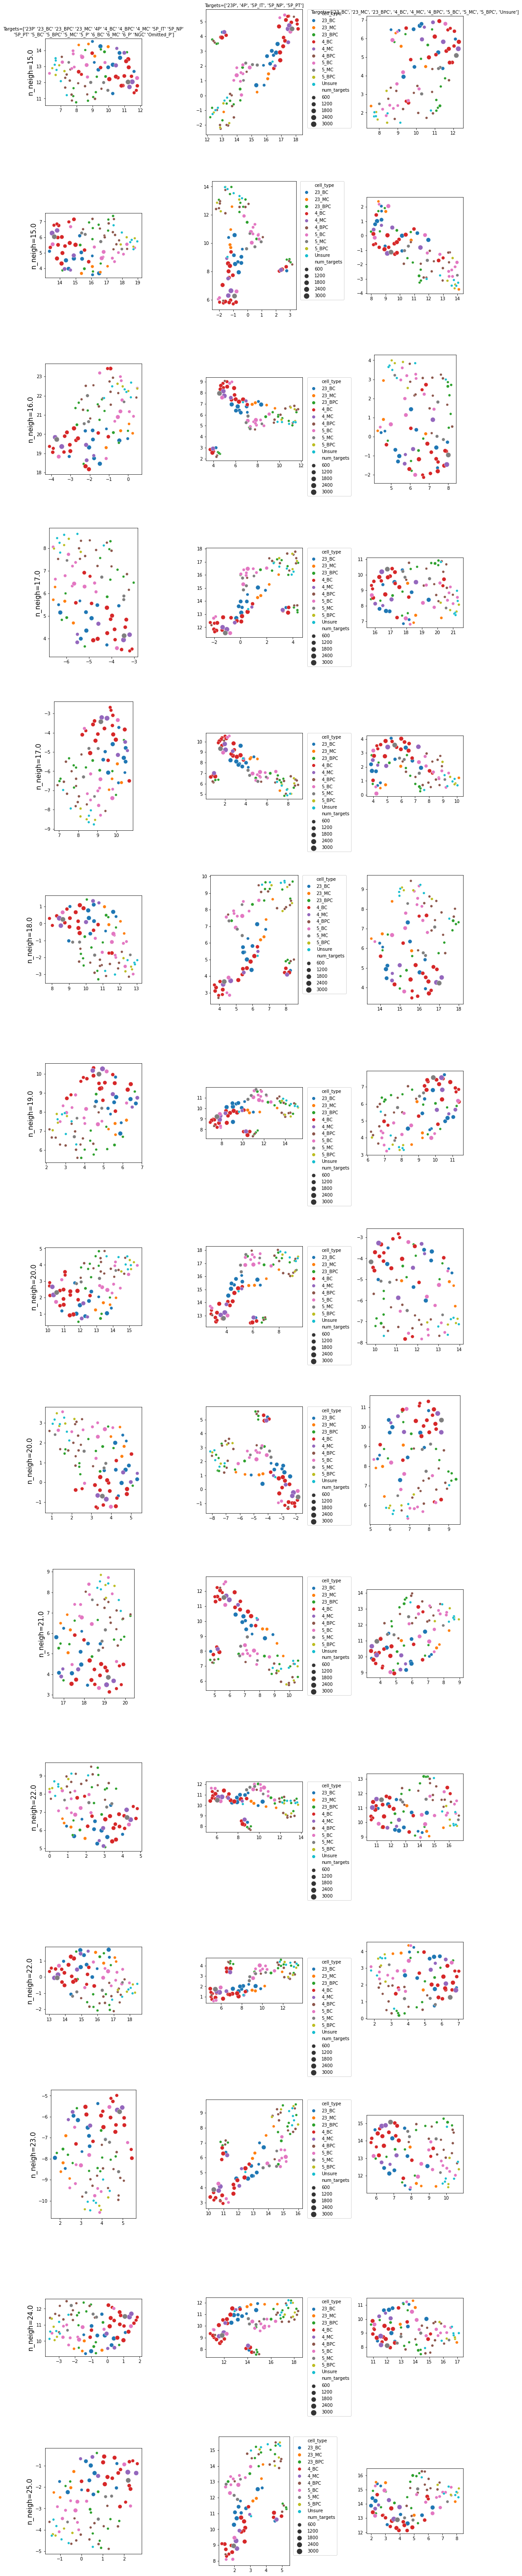

In [146]:
fig, axs = plt.subplots(numhypers, 3, figsize=(14, 81))

numhypers = 15
hype = []
neigh = np.floor(np.linspace(15,25,numhypers))
mindist = np.around(np.linspace(0.,.2,numhypers),4)
hype.append(neigh)
hype.append(mindist)

for i in tqdm(range(numhypers)):
    reducer = umap.UMAP(n_neighbors=int(hype[0][i]),min_dist=0.15)

    comb = cat[target_list].values
    reducer.fit(comb)
    embed_comb = reducer.transform(comb)
    
    comb_exc = cat[exc_targets[0:5]].values
    reducer.fit(comb_exc)
    embed_comb_exc = reducer.transform(comb_exc)
    
    comb_inh = cat[cell_types[:-1]].values
    reducer.fit(comb_inh)
    embed_comb_inh = reducer.transform(comb_inh)
    
    sns.scatterplot(data=cat, x=embed_comb[:, 0], y=embed_comb[:, 1], hue=cat.cell_type, size='num_targets', sizes=(30,130),
               ax=axs[i,0], legend=False).set_ylabel('n_neigh='+str(hype[0][i]), fontsize=15)
    axs[0,0].set_title('Targets={0:s}'.format(str(target_list)), fontsize=10)
    axs[i,0].set_aspect('equal')
    
    sns.scatterplot(data=cat, x=embed_comb_exc[:, 0], y=embed_comb_exc[:, 1], hue=cat.cell_type, size='num_targets', sizes=(30,130),
               ax=axs[i,1])
    axs[0,1].set_title('Targets={0:s}'.format(str(exc_targets[0:5])), fontsize=10)
    axs[i,1].set_aspect('equal')
    axs[i,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=10)
    
    sns.scatterplot(data=cat, x=embed_comb_inh[:, 0], y=embed_comb_inh[:, 1], hue=cat.cell_type, size='num_targets', sizes=(30,130),
                ax=axs[i,2], legend=False)
    axs[0,2].set_title('Targets={0:s}'.format(str(cell_types)), fontsize=10)
    axs[i,2].set_aspect('equal')
    
fig.tight_layout()
fig.savefig('./plots/cluster/public---neigh=15-25_min_dist=0.15_{0:s}-{1:s}bin.pdf'.format(str(up),str(r_interval)))

100%|███████████████████████████████████████████| 15/15 [07:25<00:00, 29.68s/it]


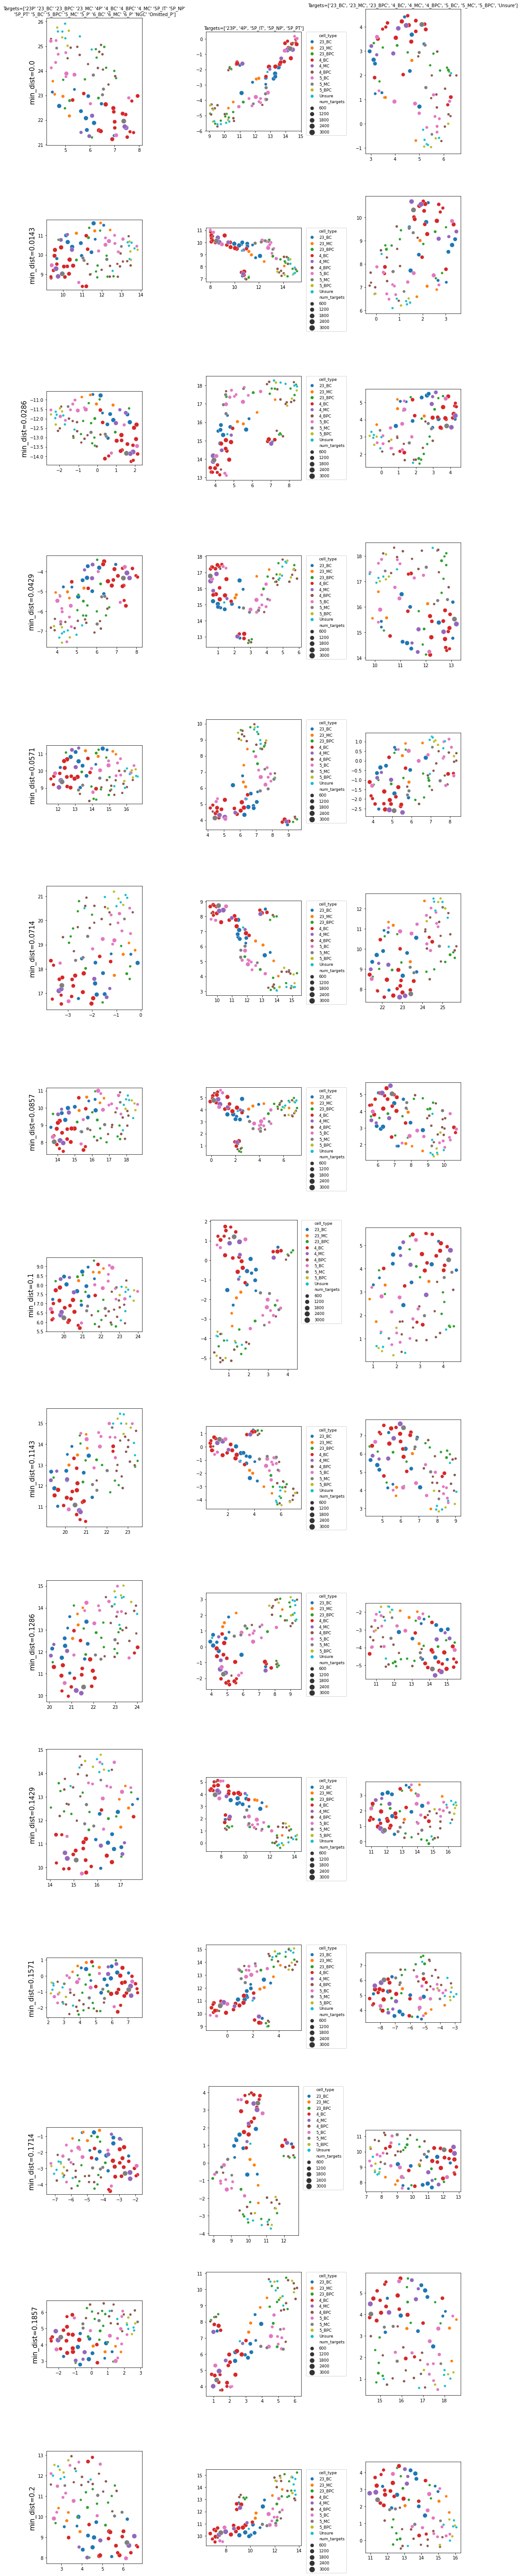

In [147]:
fig, axs = plt.subplots(numhypers, 3, figsize=(14, 81))

numhypers = 15
hype = []
neigh = np.floor(np.linspace(3,40,numhypers))
mindist = np.around(np.linspace(0.,.2,numhypers),4)
hype.append(neigh)
hype.append(mindist)

for i in tqdm(range(numhypers)):
    reducer = umap.UMAP(min_dist=hype[1][i],n_neighbors=25)

    comb = cat[target_list].values
    reducer.fit(comb)
    embed_comb = reducer.transform(comb)
    
    comb_exc = cat[exc_targets[0:5]].values
    reducer.fit(comb_exc)
    embed_comb_exc = reducer.transform(comb_exc)
    
    comb_inh = cat[cell_types[:-1]].values
    reducer.fit(comb_inh)
    embed_comb_inh = reducer.transform(comb_inh)
    
    sns.scatterplot(data=cat, x=embed_comb[:, 0], y=embed_comb[:, 1], hue=cat.cell_type, size='num_targets', sizes=(30,130),
               ax=axs[i,0], legend=False).set_ylabel('min_dist='+str(hype[1][i]), fontsize=15)
    axs[0,0].set_title('Targets={0:s}'.format(str(target_list)), fontsize=10)
    axs[i,0].set_aspect('equal')
    
    sns.scatterplot(data=cat, x=embed_comb_exc[:, 0], y=embed_comb_exc[:, 1], hue=cat.cell_type, size='num_targets', sizes=(30,130),
               ax=axs[i,1])
    axs[0,1].set_title('Targets={0:s}'.format(str(exc_targets[0:5])), fontsize=10)
    axs[i,1].set_aspect('equal')
    axs[i,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=9)
    
    sns.scatterplot(data=cat, x=embed_comb_inh[:, 0], y=embed_comb_inh[:, 1], hue=cat.cell_type, size='num_targets', sizes=(30,130),
                ax=axs[i,2], legend=False)
    axs[0,2].set_title('Targets={0:s}'.format(str(cell_types)), fontsize=10)
    axs[i,2].set_aspect('equal')
    
fig.tight_layout()
fig.savefig('./plots/cluster/public---min_dist=0-.2_neigh=25-{0:s}-{1:s}bin.pdf'.format(str(up),str(r_interval)))

In [ ]:
# sns.set(rc={'figure.figsize':(10,10)})
# sns.scatterplot(data=cat, x=embed_comb[:, 0], y=embed_comb[:, 1], hue=cat.cell_type, size='num_targets')

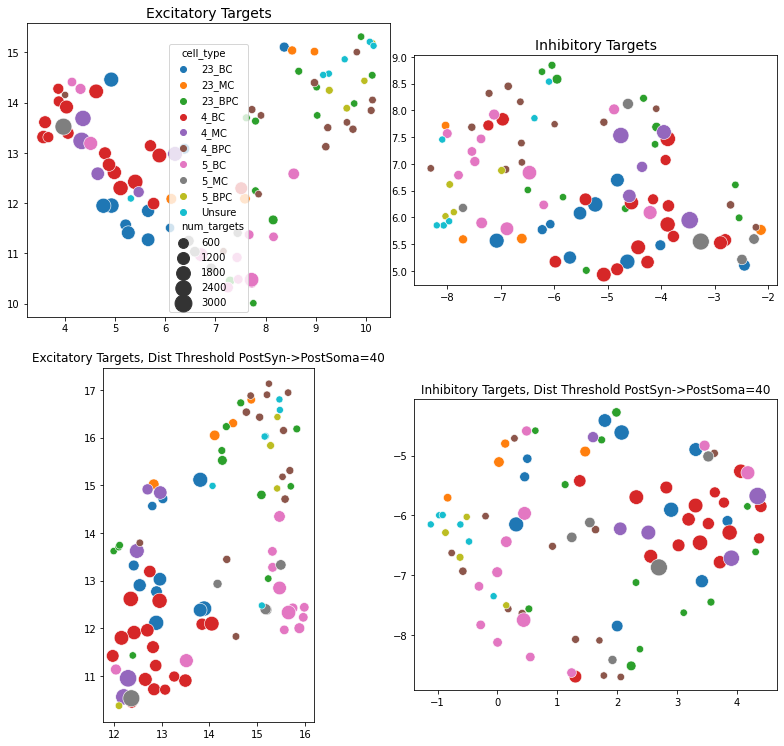

In [118]:
fig, axs = plt.subplots(2, 2, figsize=(11, 11))

sns.scatterplot(data=cat, x=embed_comb_exc[:, 0], y=embed_comb_exc[:, 1], hue=cat.cell_type, size='num_targets', sizes=(50,300),
               ax=axs[0,0]).set_title('Excitatory Targets', fontsize=12)
axs[0,0].set_aspect('equal')
sns.scatterplot(data=cat, x=embed_comb_inh[:, 0], y=embed_comb_inh[:, 1], hue=cat.cell_type, size='num_targets', sizes=(50,300),
               ax=axs[0,1], legend=False).set_title('Inhibitory Targets', fontsize=12);
axs[0,1].set_aspect('equal')
sns.scatterplot(data=cat, x=embed_comb_exc_thresh[:, 0], y=embed_comb_exc_thresh[:, 1], hue=cat.cell_type, size='num_targets', sizes=(50,300),
               ax=axs[1,0], legend=False).set_title('Excitatory Targets, Dist Threshold PostSyn->PostSoma=40', fontsize=12)
axs[1,0].set_aspect('equal')
sns.scatterplot(data=cat, x=embed_comb_inh_thresh[:, 0], y=embed_comb_inh_thresh[:, 1], hue=cat.cell_type, size='num_targets', sizes=(50,300),
               ax=axs[1,1], legend=False).set_title('Inhibitory Targets, Dist Threshold PostSyn->PostSoma=40', fontsize=12)
axs[1,1].set_aspect('equal');
fig.tight_layout()

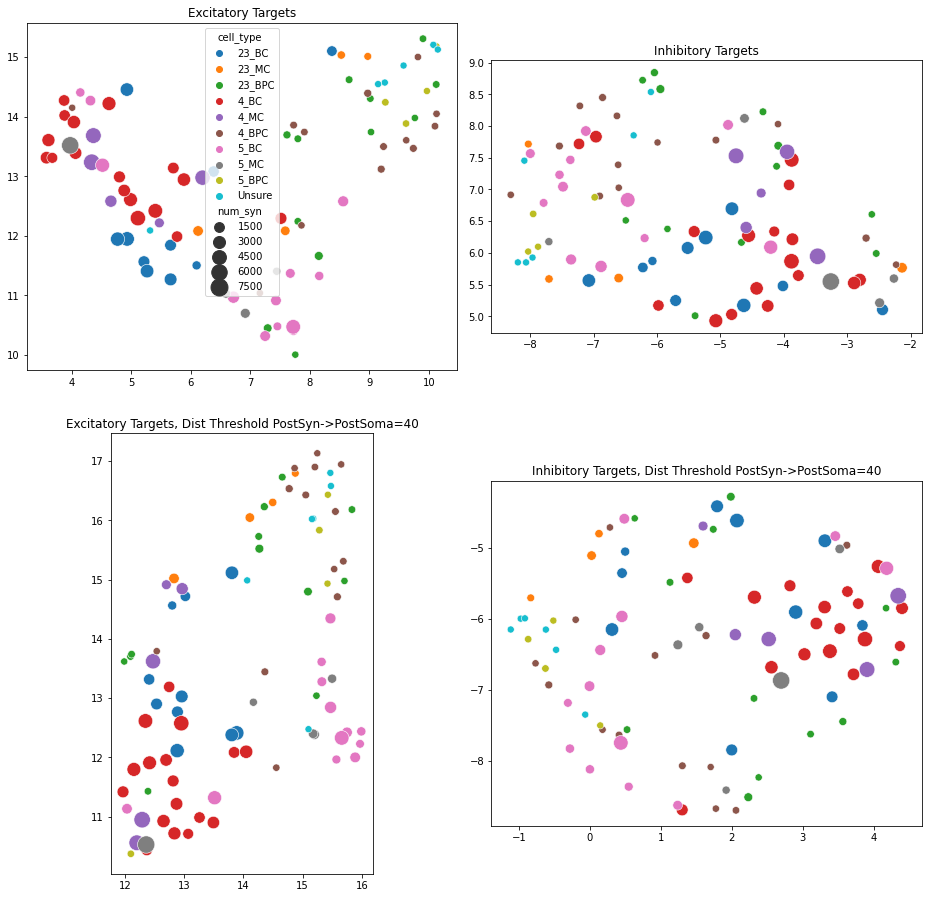

In [120]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13))

sns.scatterplot(data=cat, x=embed_comb_exc[:, 0], y=embed_comb_exc[:, 1], hue=cat.cell_type, size='num_syn', sizes=(50,300),
               ax=axs[0,0]).set_title('Excitatory Targets', fontsize=12)
axs[0,0].set_aspect('equal')
sns.scatterplot(data=cat, x=embed_comb_inh[:, 0], y=embed_comb_inh[:, 1], hue=cat.cell_type, size='num_syn', sizes=(50,300),
               ax=axs[0,1], legend=False).set_title('Inhibitory Targets', fontsize=12);
axs[0,1].set_aspect('equal')
sns.scatterplot(data=cat, x=embed_comb_exc_thresh[:, 0], y=embed_comb_exc_thresh[:, 1], hue=cat.cell_type, size='num_syn', sizes=(50,300),
               ax=axs[1,0], legend=False).set_title('Excitatory Targets, Dist Threshold PostSyn->PostSoma=40', fontsize=12)
axs[1,0].set_aspect('equal')
sns.scatterplot(data=cat, x=embed_comb_inh_thresh[:, 0], y=embed_comb_inh_thresh[:, 1], hue=cat.cell_type, size='num_syn', sizes=(50,300),
               ax=axs[1,1], legend=False).set_title('Inhibitory Targets, Dist Threshold PostSyn->PostSoma=40', fontsize=12)
axs[1,1].set_aspect('equal');
fig.tight_layout()

In [ ]:
# fig, ax = plt.subplots(1,1)
# fig.set_size_inches(15,15)

# plt.scatter(
#     embed_comb[:, 0],
#     embed_comb[:, 1],
#     hue=cat.cell_type, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of all cells', fontsize=24)

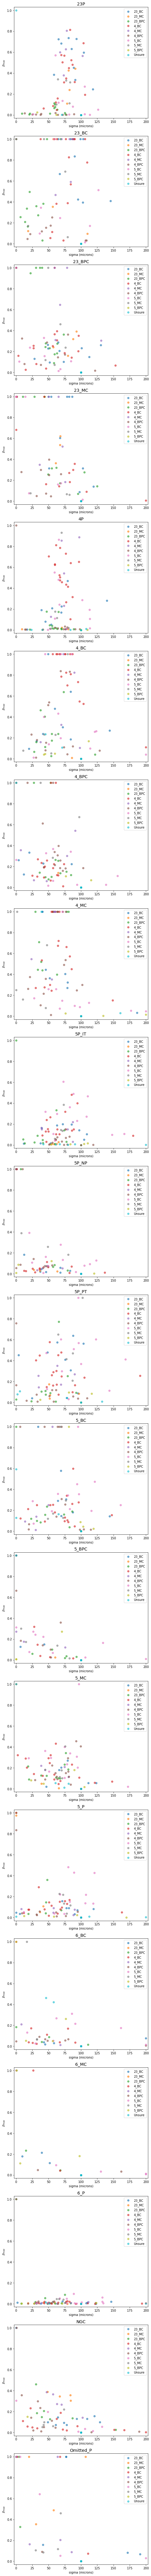

In [43]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(int(len(pmax[0])),1)
fig.set_size_inches(7,118)

for j in range(len(pmax)):
    for i in range(len(pmax[0])):
        ax[i].scatter(sigs[j][i],pmax[j][i],label=cell_types[j],alpha=.6)
        ax[i].set_xlim(-3,203)
        ax[i].set_ylim(-.03,1.03)
        ax[i].set_xlabel('sigma (microns)', fontsize=10)
        ax[i].set_ylabel(r'$p_{max}$', fontsize=10)
        ax[i].set_title(target_list[i],fontsize=14)
        ax[i].legend()

fig.tight_layout()
fig.savefig('./plots/public--MLEpmaxvsig-inh-{0:s}-{1:s}bin.pdf'.format(str(up),str(r_interval)))